In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

c:\Users\emile\Desktop\Code\MLX\ImageCaption\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load the dataset
dataset = load_dataset("nlphuji/flickr30k", split="test")

# split into train and test sets
train_test = dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Inspect the first example
example = train_dataset[0]
print(example.keys())


dict_keys(['image', 'caption', 'sentids', 'split', 'img_id', 'filename'])


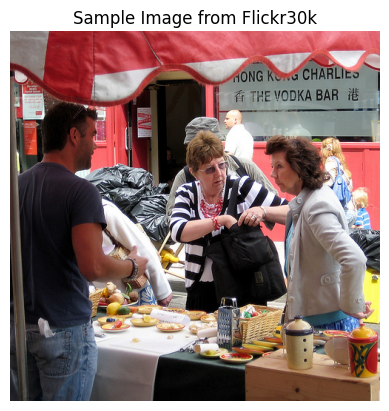

Captions:
1: Man selling food outside on a table with two ladies on the other side of the table communicating with the man.
2: A woman is reaching for something in her bag as they stand in front of a food stand.
3: Man in a blue shirt at a food stand talks to two middle-aged women.
4: Two women buying baked goods from a man at a market.
5: Two women shop at an outdoor stand in Portsmouth, UK.


In [3]:

# Display the image
plt.imshow(example['image'])
plt.axis('off')
plt.title("Sample Image from Flickr30k")
plt.show()

# Print the captions
print("Captions:")
for idx, caption in enumerate(example['caption']):
    print(f"{idx + 1}: {caption}")


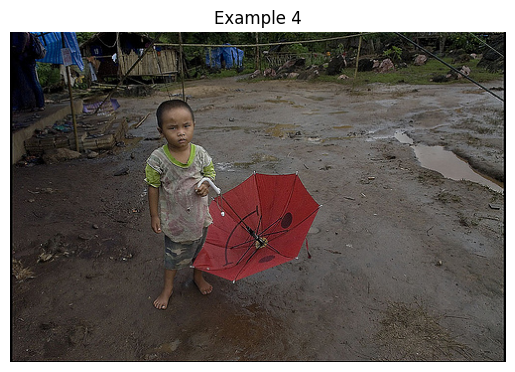

Captions for Example 4:
1: A small child holds a red umbrella upside down while standing barefoot in a muddy yard.
2: A little Asian girl standing in the mud with no shoes and holding a red umbrella.
3: A young boy is standing in muddy streets holding an umbrella.
4: A child is holding a red umbrella in the dirt.
5: A boy holds a red umbrella in a muddy yard.
--------------------------------------------------


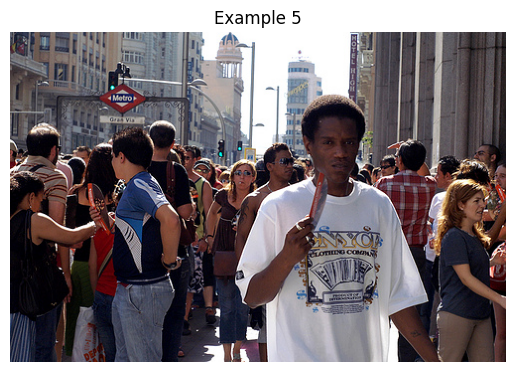

Captions for Example 5:
1: A man in a white t-shirt looks toward the camera surrounded by a crowd near a metro station.
2: A large crowd of people stand outside in front of the entrance to a Metro station.
3: A group of people are walking through a city street.
4: A crowd is portrayed near a metro station.
5: Crowd standing outside a metro area.
--------------------------------------------------


In [4]:
# Display the first 5 images with their captions
for i in range(3,5):
    example = train_dataset[i]

    # Show image
    plt.imshow(example['image'])
    plt.axis('off')
    plt.title(f"Example {i+1}")
    plt.show()

    # Show all captions
    print(f"Captions for Example {i+1}:")
    for j, caption in enumerate(example['caption']):
        print(f"{j + 1}: {caption}")
    print("-" * 50)


In [18]:
from datasets import load_dataset
from transformers import CLIPProcessor
from torch.utils.data import DataLoader
import torch

# Initialize the processor (handles both images and text)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define the function to preprocess images and captions
def preprocess_function(samples):
    # Get the first caption for each image
    captions = [caption[0] if isinstance(caption, list) else caption for caption in samples['caption']]
    
    # Process the images and tokenize the captions
    inputs = processor(
        text=captions,
        images=samples['image'],
        padding=True,
        truncation=True,
        max_length=16,
        return_tensors="pt")
    
    # Return the tokenized captions, attention masks, and processed images (already tensors)
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pixel_values': inputs['pixel_values'],  # The resized, normalized image tensors
    }

# Apply the preprocessing function to the train and test datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Define the collate function
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids'], dtype=torch.long) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch])
    pixel_values = torch.stack([torch.tensor(item['pixel_values']) for item in batch])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'pixel_values': pixel_values
    }


# Create the DataLoader for both train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

# Optional: Print the first batch from the dataloader to ensure everything is correct
for batch in train_dataloader:
    print(batch)
    break  # Only print the first batch


# Save the processed datasets to disk
train_dataset.save_to_disk("train_dataset")
test_dataset.save_to_disk("test_dataset")

Map: 100%|██████████| 6203/6203 [00:45<00:00, 136.13 examples/s]


{'input_ids': tensor([[49406,   786,  4396,  1559,  2782,   525,   320,  2175,   593,  1237,
          3431,   525,   518,  1010,  1145, 49407],
        [49406,   320,  2308, 27581,   320,  2913,  3309,   320,  4852,  1901,
          3938,  1136,   518,  2012,   530, 49407],
        [49406,   518,   736,   268,  2866,  1929, 26877,   787,  8231,   531,
         15703,   320,  2878,  2733,  3365, 49407],
        [49406,   320,  2442,  2913,  7286,   320,   736, 17143, 15362,  1136,
          1519,  2862, 30327,   530,   320, 49407],
        [49406,   320,   786,   530,   320,  1579,   339,   268,  2523,  1606,
          8508,   518,  3934, 13589,   638, 49407],
        [49406,  1888,  2909,  3309,   320,  1449,  6172,  1253,   537,   836,
          1579, 12906, 17982,   320,  1205, 49407],
        [49406,   320,  1070,  1888,  2913,   530,   320,  3144,  1746,   537,
         11193,   268,  1901,  2523,   533, 49407],
        [49406,   273,  1047,   637,  3309,   320,  1746,  2523,   51

PermissionError: Tried to overwrite C:\Users\emile\Desktop\Code\MLX\ImageCaption\train_dataset but a dataset can't overwrite itself.

In [3]:
from datasets import load_from_disk

# Load preprocessed datasets from disk
train_dataset = load_from_disk("train_dataset")
test_dataset = load_from_disk("test_dataset")


Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename', 'input_ids', 'attention_mask', 'pixel_values'],
    num_rows: 24811
})

In [8]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        assert emb_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads

        self.q_proj = nn.Linear(emb_dim, emb_dim)
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.out_proj = nn.Linear(emb_dim, emb_dim)

    def forward(self, x, mask=None):
        key = value = x
        B, N, D = x.shape
        q = self.q_proj(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).reshape(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).reshape(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            # mask: (B, 1, N, M) or (1, 1, N, M)
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(attn_scores, dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.out_proj(out)


In [9]:
class FeedForward(nn.Module):
    def __init__(self, emb_dim, ff_hidden_dim):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(emb_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, emb_dim)
        )
    def forward(self, x):
        return self.MLP(x)
    


In [10]:
### MUST ADJUST THIS
# no cross attention


class TransformerDecoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, ff_hidden_dim):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(emb_dim, num_heads)
        self.ff = FeedForward(emb_dim, ff_hidden_dim)

        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x, mask=None):
        x = x + self.self_attn(self.norm1(x), mask=mask)   # Self-attention with residual
        x = x + self.ff(self.norm2(x))                     # Feedforward with residual
        return x

In [29]:
class ImageCaptionModel(nn.Module):
    def __init__(self, num_decoder_layers, decoder_layer, emb_dim, num_heads, ff_hidden_dim, clip_model_name="openai/clip-vit-base-patch32"):
        super().__init__()

        self.clip_model = CLIPModel.from_pretrained(clip_model_name) # importing the CLIP model
        self.image_encoder = self.clip_model.vision_model # extracting the image encoder part of the CLIP model
        self.processor = CLIPProcessor.from_pretrained(clip_model_name) # extracting the image preprocessor from the CLIP model

        # Freeze CLIP image encoder parameters
        for img_param in self.image_encoder.parameters():
            img_param.requires_grad = False

        # DOUBLE CHECK THIS 
        self.text_embedding = self.clip_model.text_model.embeddings.token_embedding  # Text embedding layer
        self.text_proj = nn.Linear(512, 768)  # Project text to match image embedding dimension
        # Freeze CLIP text embedding parameters
        for text_param in self.text_embedding.parameters():
            text_param.requires_grad = False

        # Load tokenizer for the CLIP model (including BOS/EOS tokens)
        self.tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)

        # REVIEW THE DIMENSIONS HERE
        self.pos_embed = nn.Parameter(torch.randn(1, 65, emb_dim))  # 50 (img seq len) + 16 (text seq len) is max total sequence length (image + text)

        self.decoder = nn.ModuleList([
            decoder_layer(emb_dim, num_heads, ff_hidden_dim) for _ in range(num_decoder_layers)
        ])

        # Learnable output projection (to vocab size)
        self.output_layer = nn.Linear(emb_dim, self.tokenizer.vocab_size)

    def generate_causal_mask(self, attention_mask, image_len, device):
        """
        attention_mask: (B, T_text), with 1s for real tokens, 0s for padding/post-EOS
        Returns:
            mask: (B, 1, T_total, T_total)
        """
        B, T_text = attention_mask.size()
        T_total = image_len + T_text

        # Base causal mask for text
        causal_mask = torch.tril(torch.ones(T_text, T_text, device=device))  # (T_text, T_text)

        # Apply attention mask: only allow attention to non-masked tokens
        attn_mask = attention_mask.unsqueeze(1).float()  # (B, 1, T_text)
        text_mask = causal_mask.unsqueeze(0) * attn_mask  # (B, T_text, T_text)

        # Expand to full attention mask
        full_mask = torch.ones(B, T_total, T_total, device=device)

        # Image-image and image-text remain fully visible
        full_mask[:, image_len:, image_len:] = text_mask

        return full_mask.unsqueeze(1)  # (B, 1, T_total, T_total)

        
    """    
    def generate_causal_mask(self, attention_mask, seq_len, image_len, device):
        # Only apply causal mask to the text portion
        mask = torch.ones(seq_len, seq_len, device=device)
        mask = torch.tril(mask)  # Causal lower-triangular mask
        full_mask = torch.ones(seq_len + image_len, seq_len + image_len, device=device)

        # Keep image-image and image-text fully visible (no mask)
        full_mask[image_len:, image_len:] = mask  # Causal mask for text
        return full_mask.unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, total_len, total_len)
    """
    

    def decode(self, images, text_input_ids, attention_mask):
        # Encode image
        image_outputs = self.image_encoder(pixel_values=images).last_hidden_state  # (B, I, D)
        B, I, D = image_outputs.shape

        # Embed text
        text_embeds = self.text_embedding(text_input_ids)  # (B, T, D)
        text_embeds = self.text_proj(text_embeds)  # (B, T, D)

        # Concat [image | text] tokens
        combined = torch.cat([image_outputs, text_embeds], dim=1)  # (B, I+T, D)

        # Generate mask using attention mask
        mask = self.generate_causal_mask(attention_mask=attention_mask, image_len=I, device=images.device)

        pos = self.pos_embed[:, :combined.size(1), :]
        x = combined + pos
        
        for layer in self.decoder:
            x = layer(x, mask=mask)

        # Project only the text part
        output_logits = self.output_layer(x[:, I:, :])  # (B, T, vocab_size)
        return output_logits
    

    @torch.no_grad()
    def generate(self, image, max_length=18):
        """
        image: preprocessed image tensor of shape (1, 3, H, W)
        Returns: list of generated token IDs
        """
        self.eval()

        # Encode image
        image_embeds = self.image_encoder(pixel_values=image).last_hidden_state  # (1, I, D)
        image_len = image_embeds.shape[1]

        generated = [self.tokenizer.bos_token_id]  # Start with BOS token

        for _ in range(max_length):
            # Create tensor from current tokens
            input_ids = torch.tensor([generated], device=image.device)
            attention_mask = torch.ones_like(input_ids, device=image.device)  # Mask for current tokens

            # Use decode function
            logits = self.decode(image_embeds, input_ids, attention_mask)  # (1, T, vocab_size)
            next_token_logits = logits[:, -1, :]  # (1, vocab_size)

            # Greedy: choose token with highest score
            next_token = next_token_logits.argmax(dim=-1).item()
            generated.append(next_token)

            if next_token == self.tokenizer.eos_token_id:  # Use EOS token for stopping condition
                break

        return generated[1:]  # Drop BOS token


In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

def train_model(model, train_dataloader, optimizer, criterion, device, num_epochs=5):
    """
    Train the ImageCaptionModel.
    """
    print(f"[INFO] Starting training on {device}")
    model.train()
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"\n[INFO] Epoch {epoch + 1}/{num_epochs} begins")
        epoch_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, batch in enumerate(progress_bar):
            # Move batch data to the device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)


            if i == 0:
                print(f"[DEBUG] input_ids shape: {input_ids.shape}")
                print(f"[DEBUG] pixel_values shape: {pixel_values.shape}")
                print(f"[DEBUG] attention_mask shape: {attention_mask.shape}")
            
            # Forward pass
            optimizer.zero_grad()
            logits = model.decode(pixel_values, input_ids[:, :-1], attention_mask[:, :-1])  # Teacher forcing
            
            if i == 0:
                print(f"[DEBUG] logits shape: {logits.shape}")

            # Compute loss
            loss = criterion(logits.reshape(-1, logits.size(-1)), input_ids[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"[INFO] Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")


@torch.no_grad()
def evaluate_model(model, test_dataloader, criterion, device):
    """
    Evaluate the ImageCaptionModel.
    """
    print(f"\n[INFO] Starting evaluation on {device}")
    model.eval()
    model.to(device)
    
    total_loss = 0.0
    progress_bar = tqdm(test_dataloader, desc="Evaluating")
    
    for i, batch in enumerate(progress_bar):
        # Move batch data to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)

        if i == 0:
            print(f"[DEBUG] Evaluation input_ids shape: {input_ids.shape}")
        
        # Forward pass
        logits = model.decode(pixel_values, input_ids[:, :-1], attention_mask[:, :-1])
        
        # Compute loss
        loss = criterion(logits.reshape(-1, logits.size(-1)), input_ids[:, 1:].reshape(-1))
        total_loss += loss.item()

    avg_loss = total_loss / len(test_dataloader)
    print(f"[INFO] Evaluation completed. Average Loss: {avg_loss:.4f}")
    return avg_loss


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

model = ImageCaptionModel(
    num_decoder_layers=1,
    decoder_layer=TransformerDecoderBlock,
    emb_dim=768,
    num_heads=4,
    ff_hidden_dim=256
)

optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss(ignore_index=49407)  # Replace with tokenizer.pad_token_id if known

train_model(model, train_dataloader, optimizer, criterion, device, num_epochs=5)
evaluate_model(model, test_dataloader, criterion, device)


[INFO] Using device: cpu
[INFO] Starting training on cpu

[INFO] Epoch 1/5 begins


Epoch 1/5:   0%|          | 0/776 [00:00<?, ?it/s]C:\Users\emile\AppData\Local\Temp\ipykernel_8072\3230137396.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch['input_ids']).to(device)  # Convert list to tensor
C:\Users\emile\AppData\Local\Temp\ipykernel_8072\3230137396.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch['attention_mask']).to(device)  # Convert list to tensor
C:\Users\emile\AppData\Local\Temp\ipykernel_8072\3230137396.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tenso

[DEBUG] input_ids shape: torch.Size([32, 16])
[DEBUG] pixel_values shape: torch.Size([32, 3, 224, 224])
[DEBUG] attention_mask shape: torch.Size([32, 16])
[DEBUG] logits shape: torch.Size([32, 15, 49408])


Epoch 1/5:   7%|▋         | 54/776 [03:23<45:16,  3.76s/it, loss=6.67]

In [26]:
# view train_dataloader dimensions
for batch in train_dataloader:
    print(batch['input_ids'].shape)  # (B, T)
    print(batch['attention_mask'].shape)  # (B, T)
    print(batch['pixel_values'].shape)  # (B, 3, H, W)
    break  # Only print the first batch dimensions

torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 3, 224, 224])
